## UKBB+HCP Modeling

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 50.0%
RAM Usage: 17.9%
Available RAM: 827.1G
Total RAM: 1007.0G
52.4G


In [6]:
GPUtil.getAvailable()

[0]

## Load in structural connectomes

In [7]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


In [8]:
# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

## Load in functional connectomes

In [9]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


,MRID,Age,IsF,Race
0,1000038_2_0,64.64,1.0,British
1,1000108_2_0,68.39,0.0,British
2,1000149_2_0,76.67,0.0,Irish
3,1000201_2_0,67.24,1.0,British
4,1000213_2_0,67.73,1.0,British


In [10]:
UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


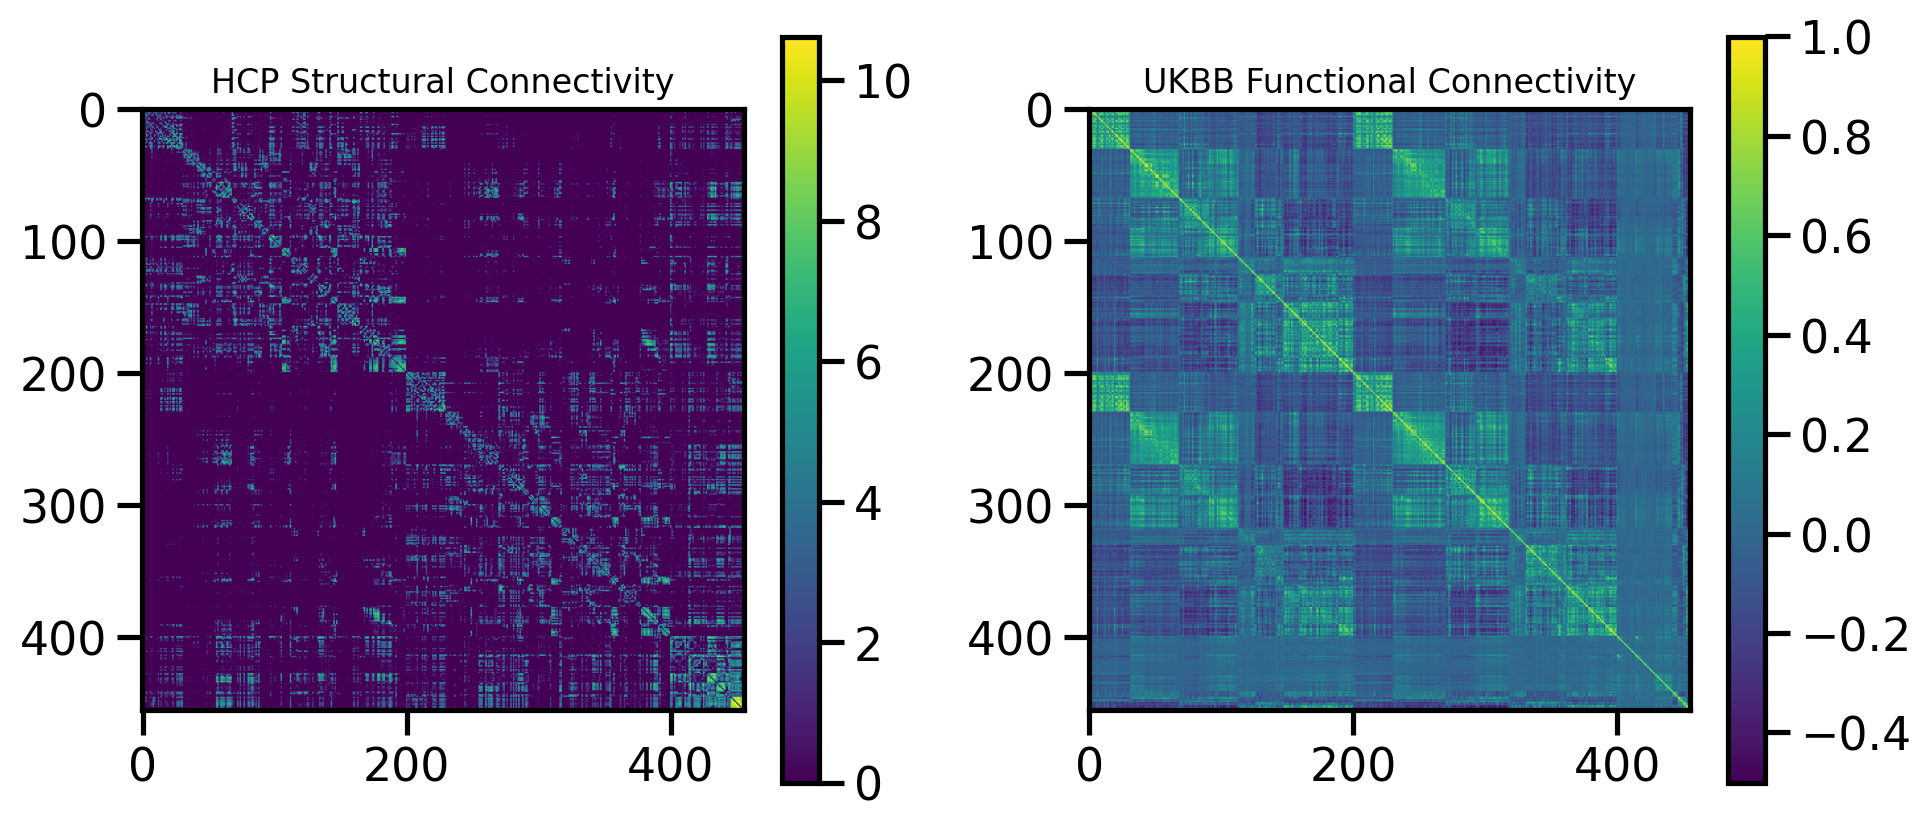

HCP Structure - UKBB Function Correlation: 0.180


In [11]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### S456 transcriptome and connectomes

In [12]:
# HCP1200 + UKBB (456)
AHBA_UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/AHBA_population_MH/'
AHBA_S456_transcriptome = pd.read_csv(os.path.join(AHBA_UKBB_path, 'AHBA_schaefer456_mean.csv'))
AHBA_S456_transcriptome


,label,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,1,0.561660,0.734501,0.324933,0.535864,0.489417,0.379832,0.326284,0.753036,0.515869,...,0.418326,0.718180,0.609211,0.559397,0.536330,0.543115,0.781127,0.494951,0.548834,0.421155
1,2,0.663557,0.685498,0.441050,0.385992,0.346175,0.443920,0.412164,0.797134,0.389222,...,0.426496,0.686967,0.631722,0.469606,0.454834,0.465253,0.669610,0.508163,0.423381,0.551138
2,3,0.436262,0.643591,0.429456,0.440705,0.431365,0.281185,0.540874,0.736296,0.423710,...,0.499867,0.573895,0.473315,0.455233,0.478429,0.496601,0.735628,0.647218,0.597632,0.566405
3,4,0.425277,0.605727,0.423479,0.535326,0.491737,0.511346,0.550680,0.797199,0.506673,...,0.598042,0.524854,0.529094,0.356172,0.607706,0.395900,0.682981,0.737804,0.598276,0.452306
4,5,0.450135,0.549051,0.424298,0.482207,0.570472,0.454508,0.502276,0.705437,0.528914,...,0.437076,0.542980,0.342298,0.269446,0.545493,0.550851,0.610388,0.740635,0.548234,0.285249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,452,0.341028,0.094848,0.765552,0.575811,0.704052,0.562898,0.461932,0.194017,0.741957,...,0.369983,0.315040,0.265321,0.670809,0.776702,0.528139,0.249857,0.221722,0.430635,0.519660
452,453,0.463658,0.186620,0.779770,0.576450,0.619368,0.611139,0.491830,0.198539,0.715724,...,0.485183,0.264759,0.221240,0.508757,0.526605,0.645608,0.192872,0.440912,0.724691,0.503096
453,454,0.330321,0.182710,0.778768,0.511883,0.645229,0.616889,0.622842,0.200763,0.715024,...,0.430804,0.199255,0.221837,0.603498,0.548253,0.459224,0.224987,0.424326,0.709733,0.528174
454,455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
UKBB_S456_atlas_info = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')

# Fill NaN network labels based on region labels
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['label'].str.contains('Cerebellar', na=False)) & 
                         (UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Cerebellum'

UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Subcortex'
print(UKBB_S456_atlas_info)


     index                label network_label      label_7network  \
0        1             LH_Vis_1           Vis  7Networks_LH_Vis_1   
1        2             LH_Vis_2           Vis  7Networks_LH_Vis_2   
2        3             LH_Vis_3           Vis  7Networks_LH_Vis_3   
3        4             LH_Vis_4           Vis  7Networks_LH_Vis_4   
4        5             LH_Vis_5           Vis  7Networks_LH_Vis_5   
..     ...                  ...           ...                 ...   
451    452   Cerebellar_Region6    Cerebellum                 NaN   
452    453   Cerebellar_Region7    Cerebellum                 NaN   
453    454   Cerebellar_Region8    Cerebellum                 NaN   
454    455   Cerebellar_Region9    Cerebellum                 NaN   
455    456  Cerebellar_Region10    Cerebellum                 NaN   

     index_17network                    label_17network  \
0               61.0  17Networks_LH_DorsAttnA_TempOcc_2   
1              193.0       17Networks_LH_DefaultC_PHC

In [14]:
# Drop rows where all values are NaN
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

nan_rows = AHBA_S456_transcriptome.isna().any(axis=1)
AHBA_S456_transcriptome = AHBA_S456_transcriptome[~nan_rows]
UKBB_S456_atlas_info = UKBB_S456_atlas_info[~nan_rows]

# Check if any NaN values remain
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

Number of rows with any NaN values: 66
Number of rows with any NaN values: 0


In [15]:
AHBA_S456_transcriptome = AHBA_S456_transcriptome.drop('label', axis=1)
AHBA_S456_transcriptome

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.561660,0.734501,0.324933,0.535864,0.489417,0.379832,0.326284,0.753036,0.515869,0.657180,...,0.418326,0.718180,0.609211,0.559397,0.536330,0.543115,0.781127,0.494951,0.548834,0.421155
1,0.663557,0.685498,0.441050,0.385992,0.346175,0.443920,0.412164,0.797134,0.389222,0.608480,...,0.426496,0.686967,0.631722,0.469606,0.454834,0.465253,0.669610,0.508163,0.423381,0.551138
2,0.436262,0.643591,0.429456,0.440705,0.431365,0.281185,0.540874,0.736296,0.423710,0.706882,...,0.499867,0.573895,0.473315,0.455233,0.478429,0.496601,0.735628,0.647218,0.597632,0.566405
3,0.425277,0.605727,0.423479,0.535326,0.491737,0.511346,0.550680,0.797199,0.506673,0.609379,...,0.598042,0.524854,0.529094,0.356172,0.607706,0.395900,0.682981,0.737804,0.598276,0.452306
4,0.450135,0.549051,0.424298,0.482207,0.570472,0.454508,0.502276,0.705437,0.528914,0.501061,...,0.437076,0.542980,0.342298,0.269446,0.545493,0.550851,0.610388,0.740635,0.548234,0.285249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.356165,0.136111,0.794895,0.432077,0.550255,0.820798,0.693197,0.242186,0.777254,0.096343,...,0.289390,0.340671,0.309953,0.747729,0.684998,0.626211,0.235771,0.563802,0.611799,0.575709
451,0.341028,0.094848,0.765552,0.575811,0.704052,0.562898,0.461932,0.194017,0.741957,0.298705,...,0.369983,0.315040,0.265321,0.670809,0.776702,0.528139,0.249857,0.221722,0.430635,0.519660
452,0.463658,0.186620,0.779770,0.576450,0.619368,0.611139,0.491830,0.198539,0.715724,0.273334,...,0.485183,0.264759,0.221240,0.508757,0.526605,0.645608,0.192872,0.440912,0.724691,0.503096
453,0.330321,0.182710,0.778768,0.511883,0.645229,0.616889,0.622842,0.200763,0.715024,0.291594,...,0.430804,0.199255,0.221837,0.603498,0.548253,0.459224,0.224987,0.424326,0.709733,0.528174


In [16]:
# Get list of genes from schaefer 100 data
genes_data = pd.read_csv(f"./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
genes_list = genes_data.columns.tolist()
genes_list.remove('label')

# Subset AHBA_S456 to only include these genes 
AHBA_S456_transcriptome = AHBA_S456_transcriptome[genes_list]


AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (456, 456)
UKBB_S456_functional_conn shape: (456, 456)


Text(0.5, 1.0, 'HCP1200 Structural Connectivity (nan rows removed)')

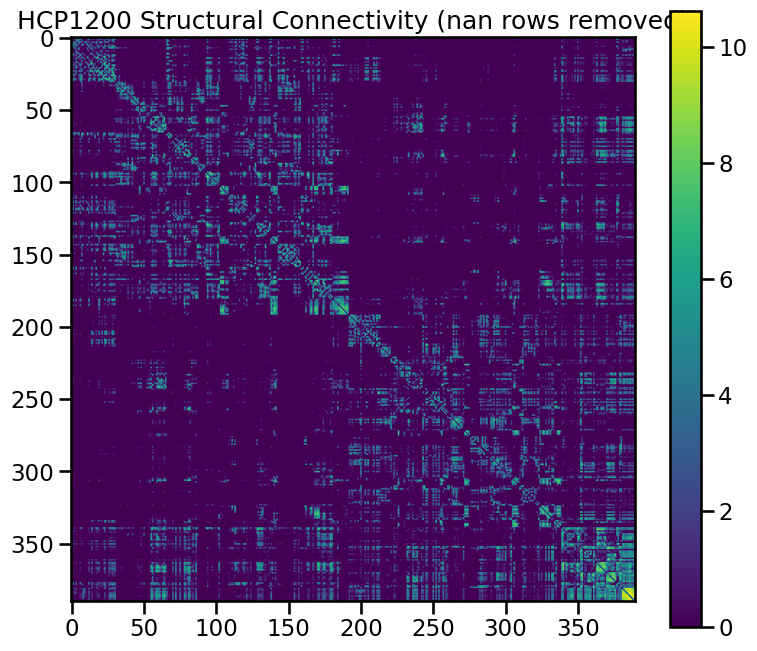

In [17]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

# Store labels and network labels from atlas info
region_labels = UKBB_S456_atlas_info['label'].tolist()
network_labels = UKBB_S456_atlas_info['network_label'].tolist()

# Remove nan rows and columns from connectomes using nan_rows directly
HCP1200_S456_structural_count = HCP1200_S456_structural_count[~nan_rows][:, ~nan_rows]

# Display resulting connectomes
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP1200 Structural Connectivity (nan rows removed)')


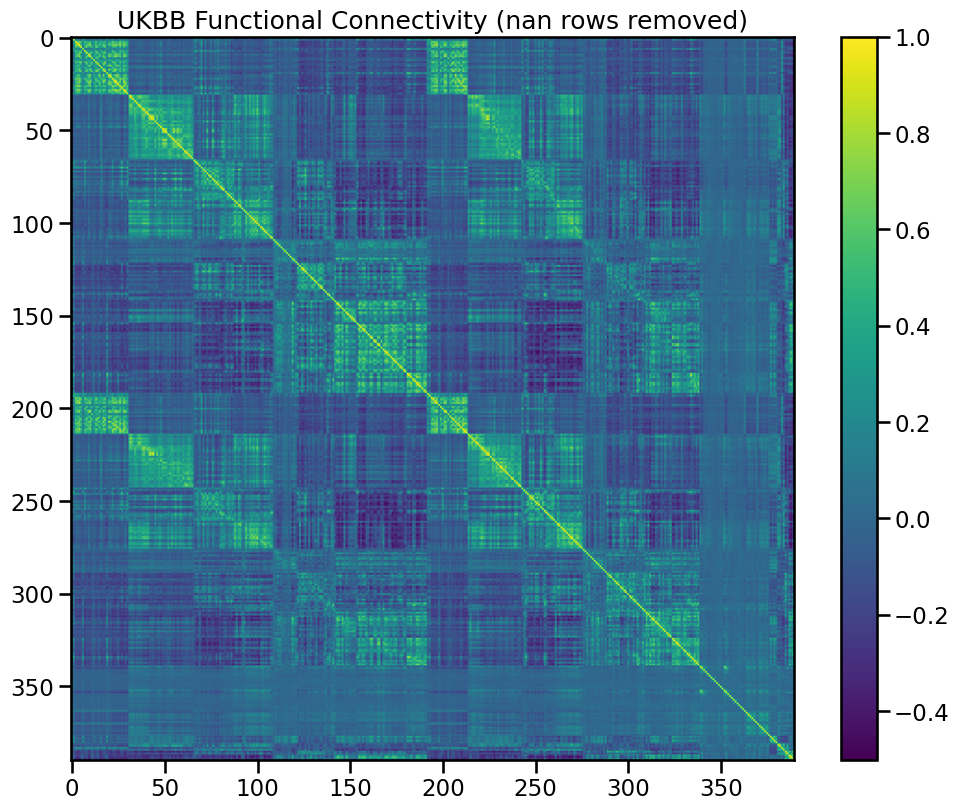

In [18]:

plt.figure(figsize=(20, 8))

UKBB_S456_functional_conn = np.array(UKBB_S456_functional_conn)[~nan_rows][:, ~nan_rows]
plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar()
plt.title('UKBB Functional Connectivity (nan rows removed)')

plt.tight_layout()
plt.show()

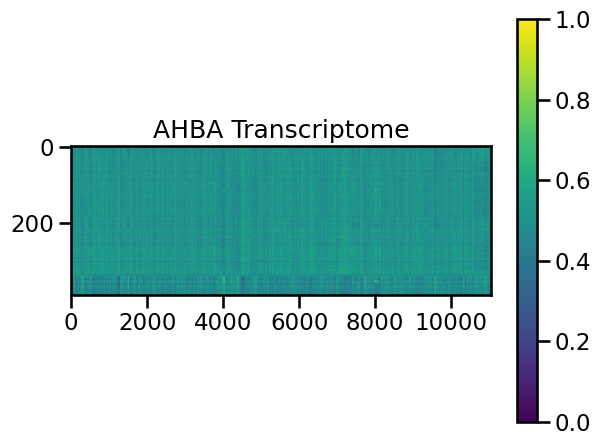

In [19]:
plt.imshow(AHBA_S456_transcriptome, cmap='viridis', aspect=10)
plt.title('AHBA Transcriptome')
plt.colorbar()
plt.tight_layout()
plt.show()


In [20]:
network_labels = UKBB_S456_atlas_info['network_label'].tolist()
region_labels = UKBB_S456_atlas_info['label'].tolist()
print("Network labels shape:", len(network_labels))
print("Region labels shape:", len(region_labels))


Network labels shape: 390
Region labels shape: 390


In [21]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (390, 390)
UKBB_S456_functional_conn shape: (390, 390)


In [22]:
# Filter out subcortex and cerebellum networks
cortical_mask = ~np.array([label in ['Subcortex', 'Cerebellum'] for label in network_labels])
AHBA_cortical_transcriptome = np.array(AHBA_S456_transcriptome)[cortical_mask]
cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]

# Filter structural and functional connectivity matrices using cortical mask
HCP1200_S456_structural_count_cortical = np.array(HCP1200_S456_structural_count)[cortical_mask][:, cortical_mask]
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[cortical_mask][:, cortical_mask]

print("Cortical transcriptome shape:", AHBA_cortical_transcriptome.shape)
print("Cortical structural connectivity shape:", HCP1200_S456_structural_count_cortical.shape)
print("Cortical functional connectivity shape:", UKBB_S456_functional_conn_cortical.shape)

Cortical transcriptome shape: (339, 11053)
Cortical structural connectivity shape: (339, 339)
Cortical functional connectivity shape: (339, 339)


### Modeling tests

In [23]:
X = AHBA_cortical_transcriptome
Y_sc = HCP1200_S456_structural_count_cortical
Y_fc = UKBB_S456_functional_conn_cortical

In [24]:
cv_obj = RandomCVSplit(X, Y_fc, num_splits=4, shuffled=True, use_random_state=True, random_seed=42)
cv_obj.display_splits()

TRAIN: [  0   1   2   4   6   8  10  11  12  13  14  15  17  18  19  20  21  22
  23  24  26  27  28  29  30  31  32  34  35  36  37  38  40  41  43  44
  47  48  49  50  51  52  53  54  56  58  59  61  62  64  65  67  68  69
  70  71  74  79  80  81  83  85  86  87  88  89  91  92  93  95  96  97
  98  99 100 102 103 105 106 107 111 112 115 117 120 121 122 123 125 127
 128 129 130 131 132 133 134 135 136 138 140 141 142 143 146 148 149 150
 151 152 153 154 156 157 159 160 161 162 163 164 166 167 168 169 170 171
 174 175 177 178 179 180 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 200 201 202 204 205 206 207 209 211 212 213 214 215 216 217 218
 219 220 222 223 224 225 226 227 229 230 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 255 256 257 258
 259 260 262 263 264 265 267 268 269 270 271 273 274 275 276 277 279 281
 282 283 285 287 288 289 290 291 292 293 294 295 297 299 301 303 304 307
 308 309 310 311 312 313 318 320 321 322 323

In [25]:
fold_splits = process_cv_splits(X, Y_fc, cv_obj)

In [26]:
for fold_idx, (X_train, X_test, Y_train, Y_test) in enumerate(fold_splits):
    print('\n', f'Test fold num: {fold_idx+1}')
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = X_train, X_test, Y_train, Y_test
            


 Test fold num: 1
(64262, 22106) (64262,) (7140, 22106) (7140,)

 Test fold num: 2
(64262, 22106) (64262,) (7140, 22106) (7140,)

 Test fold num: 3
(64262, 22106) (64262,) (7140, 22106) (7140,)

 Test fold num: 4
(64770, 22106) (64770,) (6972, 22106) (6972,)


In [27]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 50.0%
RAM Usage: 22.6%
Available RAM: 779.8G
Total RAM: 1007.0G
52.4G


In [28]:
print(X_train_fold.shape, Y_train_fold.shape, X_test_fold.shape, Y_test_fold.shape)


(64770, 22106) (64770,) (6972, 22106) (6972,)


In [29]:
# compute PCA to test if size is the problem...

In [30]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# ElasticNet model
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)  # Adjust alpha/l1_ratio as needed
elastic_net.fit(X_train_fold, Y_train_fold)

# Predictions
elastic_net_preds = elastic_net.predict(X_test_fold)

# Evaluation
mse_en = mean_squared_error(Y_test_fold, elastic_net_preds)
mae_en = mean_absolute_error(Y_test_fold, elastic_net_preds)
r2_en = r2_score(Y_test_fold, elastic_net_preds)
pearson_r_en, _ = pearsonr(Y_test_fold, elastic_net_preds)

# Output metrics
print("\nElasticNet Performance:")
print(f"RMSE: {mse_en ** 0.5:.4f}")
print(f"MSE: {mse_en:.4f}")
print(f"MAE: {mae_en:.4f}")
print(f"R^2: {r2_en:.4f}")
print(f"Pearson-r: {pearson_r_en:.4f}")


ElasticNet Performance:
RMSE: 0.2163
MSE: 0.0468
MAE: 0.1716
R^2: -0.0016
Pearson-r: nan


In [31]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Configure the PLS model
n_components = 10  # Number of components to retain; adjust based on your data
pls_model = PLSRegression(n_components=n_components)

# Fit the PLS model
pls_model.fit(X_train_fold, Y_train_fold)

# Predictions
pls_preds = pls_model.predict(X_test_fold).flatten()  # Flatten to 1D array

# Evaluate performance
mse_pls = mean_squared_error(Y_test_fold, pls_preds)
mae_pls = mean_absolute_error(Y_test_fold, pls_preds)
r2_pls = r2_score(Y_test_fold, pls_preds)
pearson_r_pls, _ = pearsonr(Y_test_fold, pls_preds)

# Output metrics
print("\nPartial Least Squares Regression Performance:")
print(f"RMSE: {mse_pls ** 0.5:.4f}")
print(f"MSE: {mse_pls:.4f}")
print(f"MAE: {mae_pls:.4f}")
print(f"R^2: {r2_pls:.4f}")
print(f"Pearson-r: {pearson_r_pls:.4f}")

KeyboardInterrupt: 

In [32]:
from xgboost import XGBRegressor

# XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,  # Number of trees
    max_depth=6,       # Maximum tree depth
    learning_rate=0.1, # Learning rate
    tree_method="gpu_hist", # GPU-accelerated algorithm
    predictor="gpu_predictor", # Use GPU for predictions
    random_state=42    # For reproducibility
)
xgb_model.fit(X_train_fold, Y_train_fold)

# Predictions
xgb_preds = xgb_model.predict(X_test_fold)

# Evaluation
mse_xgb = mean_squared_error(Y_test_fold, xgb_preds)
mae_xgb = mean_absolute_error(Y_test_fold, xgb_preds)
r2_xgb = r2_score(Y_test_fold, xgb_preds)
pearson_r_xgb, _ = pearsonr(Y_test_fold, xgb_preds)

# Output metrics
print("\nXGBoost Performance:")
print(f"RMSE: {mse_xgb ** 0.5:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R^2: {r2_xgb:.4f}")
print(f"Pearson-r: {pearson_r_xgb:.4f}")


XGBoost Performance:
RMSE: 0.1880
MSE: 0.0353
MAE: 0.1457
R^2: 0.2432
Pearson-r: 0.4997


In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# GPU-accelerated XGBoost with regularization
xgb_gpu_regularized = XGBRegressor(
    n_estimators=200,       # Increase boosting rounds for better performance
    max_depth=4,            # Shallower trees to prevent overfitting
    learning_rate=0.05,     # Lower learning rate
    tree_method="gpu_hist", # GPU-accelerated algorithm
    predictor="gpu_predictor", # Use GPU for predictions
    random_state=42,        # For reproducibility
    reg_alpha=1.0,          # L1 regularization (default: 0)
    reg_lambda=10.0,        # L2 regularization (default: 1)
    min_child_weight=10,    # Minimum weight in leaf (default: 1)
    subsample=0.8,          # Use 80% of data for each tree
    colsample_bytree=0.8    # Use 80% of features for each tree
)

# Fit the model
xgb_gpu_regularized.fit(X_train_fold, Y_train_fold)

# Predictions
xgb_gpu_regularized_preds = xgb_gpu_regularized.predict(X_test_fold)

# Evaluation
mse_xgb_gpu_reg = mean_squared_error(Y_test_fold, xgb_gpu_regularized_preds)
mae_xgb_gpu_reg = mean_absolute_error(Y_test_fold, xgb_gpu_regularized_preds)
r2_xgb_gpu_reg = r2_score(Y_test_fold, xgb_gpu_regularized_preds)
pearson_r_xgb_gpu_reg, _ = pearsonr(Y_test_fold, xgb_gpu_regularized_preds)

# Output metrics
print("\nRegularized GPU-Accelerated XGBoost Performance:")
print(f"RMSE: {mse_xgb_gpu_reg ** 0.5:.4f}")
print(f"MSE: {mse_xgb_gpu_reg:.4f}")
print(f"MAE: {mae_xgb_gpu_reg:.4f}")
print(f"R^2: {r2_xgb_gpu_reg:.4f}")
print(f"Pearson-r: {pearson_r_xgb_gpu_reg:.4f}")


Regularized GPU-Accelerated XGBoost Performance:
RMSE: 0.1893
MSE: 0.0358
MAE: 0.1468
R^2: 0.2324
Pearson-r: 0.5169


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_fold)
X_test = scaler.transform(X_test_fold)

In [ ]:
print(Y_test_true)

In [ ]:
print(predictions)

In [ ]:
from flaml import AutoML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Adjusted: Assume X_train and Y_train are larger training samples
# Assuming you have X_train and Y_train with increased sample size
# X_train_fold and Y_train_fold are subsets if needed for testing purposes

# Initialize FLAML AutoML
automl = AutoML()

# Configure FLAML with additional models and metrics
automl_settings = {
    "time_budget": 60,               # Total time in seconds
    "task": "regression",             # Specify the task type
    "metric": "rmse",                 # Optimize for RMSE
    "estimator_list": ['xgboost', 'rf', 'lrl1', 'lrl2'],
    "log_file_name": "flaml_log.txt", # Log file to record progress
    "seed": 42,                       # For reproducibility
}

# Train the AutoML model
automl.fit(X_train=X_train_fold, y_train=Y_train_fold, **automl_settings)

# Display the best model
print("Best model:", automl.best_estimator)
print("Best hyperparameters:", automl.best_config)

# Predict on the test set
predictions = automl.predict(X_test_fold)

# Evaluate performance
mse = mean_squared_error(Y_test_fold, predictions)
mae = mean_absolute_error(Y_test_fold, predictions)
r2 = r2_score(Y_test_fold, predictions)
pearson_r, _ = pearsonr(Y_test_fold, predictions)

# Output all metrics
print("\nPerformance Metrics:")
print(f"RMSE: {mse ** 0.5:.4f}")  # RMSE is the square root of MSE
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")
print(f"Pearson-r: {pearson_r:.4f}")

In [35]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# Initialize H2O cluster
h2o.init(max_mem_size="8G", nthreads=4)

# Convert your training and testing data into H2O frames
X_train_fold_h2o = h2o.H2OFrame(X_train_fold)
Y_train_fold_h2o = h2o.H2OFrame(Y_train_fold.reshape(-1, 1))  # Reshape to a column
X_test_fold_h2o = h2o.H2OFrame(X_test_fold)
Y_test_fold_h2o = h2o.H2OFrame(Y_test_fold.reshape(-1, 1))    # Reshape to a column

# Combine X and Y for H2O AutoML
train_h2o = X_train_fold_h2o.cbind(Y_train_fold_h2o)
test_h2o = X_test_fold_h2o.cbind(Y_test_fold_h2o)

# Set the target column name
target = "target"
train_h2o.set_names(["feature_" + str(i) for i in range(X_train_fold.shape[1])] + [target])
test_h2o.set_names(["feature_" + str(i) for i in range(X_test_fold.shape[1])] + [target])

# Define the features and target
x = train_h2o.columns[:-1]  # Features
y = train_h2o.columns[-1]   # Target

# Run H2O AutoML
aml = H2OAutoML(
    max_models=40,          # Number of models to train
    max_runtime_secs=6000,   # Maximum runtime in seconds
    seed=42,                # For reproducibility
    sort_metric="RMSE",     # Optimize for regression metric
)

aml.train(x=x, y=y, training_frame=train_h2o)

# Evaluate the leaderboard
print("Leaderboard:")
print(aml.leaderboard)

# Predict on the test set
predictions = aml.predict(test_h2o)

# Convert predictions to a NumPy array for evaluation
predictions_np = h2o.as_list(predictions, use_pandas=True).values.flatten()
actuals_np = Y_test_fold

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(actuals_np, predictions_np))
print("MAE:", mean_absolute_error(actuals_np, predictions_np))
print("R^2:", r2_score(actuals_np, predictions_np))
print("Pearson-r:", pearsonr(actuals_np.flatten(), predictions_np.flatten()))

# Shut down H2O cluster
h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /ext3/miniconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /state/partition1/job-54353991/tmp0n_hw4rw
  JVM stdout: /state/partition1/job-54353991/tmp0n_hw4rw/h2o_asr655_started_from_python.out
  JVM stderr: /state/partition1/job-54353991/tmp0n_hw4rw/h2o_asr655_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_asr655_f1uag8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"
